In [1]:
from io import BytesIO
from matplotlib.backends.backend_pdf import PdfPages
from onnx import load_model, save_model
from onnx.compose import add_prefix, merge_models
from onnxmltools.convert import convert_xgboost
from onnxmltools.convert.common.data_types import FloatTensorType
from pathlib import Path
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import os
import pandas as pd
import seaborn as sns


# Data directory and globals

In [2]:
# Define the directory containing the lens data (this is a private repository)
data_dir = Path('camflex-data/data')

# Define the output CSV file path
output_csv_path =Path('camflex-data/training_data.csv')

# Path to the PDF file containing the lens data
pdf_path = Path('lens_data.pdf')

# Define model_dir
model_dir = Path('models')

# Sanity check

In [3]:
def directory_exists(path):
  """Checks if a directory exists.

  Args:
    path: The path to the directory.

  Returns:
    True if the directory exists, False otherwise.
  """
  isdir = os.path.isdir(path)
  if isdir:
    print(f"Directory '{path}' exists.")
  else:
    print(f"Directory '{path}' does not exist.")
  return os.path.isdir(path)

directory_exists(data_dir)
directory_exists(model_dir)

if os.path.isfile(output_csv_path):
  print(f"File '{output_csv_path}' exists.")
else:
  print(f"File '{output_csv_path}' does not exist.")

Directory 'camflex-data\data' exists.
Directory 'models' exists.
File 'camflex-data\training_data.csv' exists.


# Load existing training data

In [4]:
def load_training_data(output_csv_path):
  """Loads the training data from a CSV file.

  Returns:
    A DataFrame containing the training data.
  """
  return pd.read_csv(output_csv_path)

In [5]:
def printLensNames(data):
    # Get unique lens names
    unique_lens_names = data['LensName'].unique()

    # Report SensorW and SensorH for each unique lens name
    for cam in unique_lens_names:
        lens_data = data[data['LensName'] == cam]
        sensor_w = lens_data['FocalLength_cm'].unique()
        print(f"Camera: {cam} FocalLength: {sensor_w * 10}")

In [6]:
def get_distortion(camera_name, distance, data):
    # rows for camera_name
    camera_data = data[data['CameraName'] == camera_name]
    # get the row where distance is closest to the given distance
    row = camera_data.iloc[(camera_data['Distance_cm'] - distance).abs().argsort()[:1]]
    return row['K1'].values[0], row['K2'].values[0]

In [7]:
def get_camera_sensor_size(camera_name, data):
    """
    Returns the SensorWidth_cm and SensorHeight_cm for a given CameraName.

    Args:
        camera_name (str): The name of the camera.
        data (pd.DataFrame): The DataFrame containing the data.

    Returns:
        tuple: (SensorWidth_cm, SensorHeight_cm) if the camera is found, otherwise (None, None).
    """
    if camera_name not in data['CameraName'].unique():
        print(f"Camera '{camera_name}' not found in the data.")
        return None, None
    
    
    camera_data = data[data['CameraName'] == camera_name]
    if not camera_data.empty:
        sensor_width = camera_data['SensorWidth_cm'].iloc[0]
        sensor_height = camera_data['SensorHeight_cm'].iloc[0]
        return sensor_width, sensor_height
    else:
        KeyError(f"Camera '{camera_name}' not found in the data.")
        return None, None

# Plot data to PDF

In [8]:
def generate_lens_analysis_plots(data, pdf_path):
    """
    Generate and save scatter plots analyzing lens data to a PDF.

    Args:
        csv_training_data (DataFrame): Input data containing lens and camera details.
        pdf_path (str): File path to save the output PDF.
    """
    # Create a global color palette for consistent colors across all figures
    unique_camera_names = data['CameraName'].unique()
    color_mapping = dict(zip(unique_camera_names, sns.color_palette("colorblind", len(unique_camera_names))))

    # Open a PdfPages object to save figures
    with PdfPages(pdf_path) as pdf:
        lens_names = data['LensName'].unique()

        for lens_name in lens_names:
            plt.figure(figsize=(18, 12))  # Set figure size
            plt.suptitle(f'Data for Lens Name: {lens_name}', fontsize=14)

            # Filter data for the current lens name
            lens_data = data[data['LensName'] == lens_name]

            if lens_data.empty:
                continue  # Skip if no data for this lens

            # Create each subplot and rasterize it
            y_columns_titles = [
                ('K1', 'Distance vs K1'),
                ('K2', 'Distance vs K2'),
                ('U2', 'Distance vs U2'),
                ('V2', 'Distance vs V2'),
                ('U4', 'Distance vs U4'),
                ('V4', 'Distance vs V4')
            ]
            for idx, (y_col, title) in enumerate(y_columns_titles):
                plt.subplot(3, 2, idx + 1)
                sns.scatterplot(
                    data=lens_data,
                    x='Distance_cm',
                    y=y_col,
                    hue='CameraName',
                    palette=color_mapping,
                    s=10,
                    alpha=0.7,
                    legend=False  # Disable legend for subplots
                )
                plt.xscale('log')
                plt.xlabel('Distance (log scale)')
                plt.ylabel(y_col)
                plt.title(title)

                # Rasterize the subplot
                plt.gca().set_rasterized(True)

            # Create a single legend for the figure
            handles = [
                plt.Line2D([0], [0], marker='o', color=color_mapping[camera],
                           linestyle='', markersize=5) 
                for camera in unique_camera_names
            ]
            plt.figlegend(
                handles,
                unique_camera_names,
                title="Camera Name",
                loc='center left',
                bbox_to_anchor=(.85, 0.5),  # Adjust to position closer to the subplots
                borderaxespad=0,
            )

            # Adjust subplot spacing
            plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Adjust layout to fit legend
            plt.subplots_adjust(hspace=0.4, wspace=0.15)

            # Save the current figure to the PDF as a rasterized bitmap
            pdf.savefig(dpi=96)  # Specify DPI for bitmap quality
            plt.close()  # Close the figure to free memory

        print(f"All figures have been saved to {pdf_path}.")



# Visualize the parameter correlations

In [9]:
def plot_correlations(data):
    # Correlation matrix to check the relationships between the variables
    corr_matrix = data[['Distance_cm', 'K1', 'K2', 'U2', 'V2', 'U4', 'V4', 'SensorWidth_cm', 'SensorHeight_cm', 'FocalLength_cm']].corr()

    # Plotting the correlation matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='PiYG', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

# Fixup the training data

In [10]:
def prepare_training_data(training_data, column_name, value_to_exclude):
    """
    Prepare the training data by:
    - Duplicating K1 and K2 columns to K1t and K2t
    - Extracting and removing rows where column_name equals value_to_exclude
    - Removing entries with insufficient data

    Args:
        training_data (pd.DataFrame): The original training data DataFrame.
        column_name (str): The name of the column to filter on.
        value_to_exclude (str): The value in the column to exclude from training_data.

    Returns:
        tuple: (updated_training_data, excluded_data)
    """
    # Duplicate the K1 and K2 columns as K1t and K2t
    training_data['K1t'] = training_data['K1']
    training_data['K2t'] = training_data['K2']

    # Extract the specified rows based on the column and value
    excluded_data = training_data[training_data[column_name] == value_to_exclude]

    # Update training_data to exclude the specified rows
    updated_training_data = training_data[training_data[column_name] != value_to_exclude]

    # Remove lenses with insufficient data
    lenses_to_remove = ['ZEISS_Supreme_040mm', 'ZEISS_Supreme_065mm']
    updated_training_data = updated_training_data[~updated_training_data['LensName'].isin(lenses_to_remove)]

    return updated_training_data, excluded_data




# Save ONNX

In [11]:
def save_xgboost_to_onnx(model, scaler, model_path: Path, input_shape: int, feature_names: list):
    """
    Save an XGBoost model to ONNX format, including scaler and feature labels in metadata.

    Parameters:
    - model: Trained XGBoost model to save.
    - model_path: Path object specifying the save location of the ONNX file.
    - input_shape: Number of input features.
    - feature_names: List of feature names corresponding to input features.
    - scaler: Pre-trained scaler object to save alongside the model.
    """
    if input_shape <= 0:
        raise ValueError("Input shape must be a positive integer.")

    if len(feature_names) != input_shape:
        raise ValueError("Feature names count must match input shape.")

    # Map custom feature names to 'f%d' format required by ONNX conversion
    generic_feature_names = [f"f{i}" for i in range(input_shape)]
    feature_name_mapping = dict(zip(generic_feature_names, feature_names))

    # Ensure consistent opset version
    target_opset = 10

    # Convert the scaler to ONNX
    scaler_onnx = convert_sklearn(
        scaler,
        initial_types=[('float_input', FloatTensorType([None, input_shape]))],
        target_opset=target_opset
    )

    # Convert the XGBoost model to ONNX
    model.get_booster().feature_names = generic_feature_names
    initial_type = [('float_input', FloatTensorType([None, input_shape]))]
    xgb_onnx = convert_xgboost(model, initial_types=initial_type, target_opset=target_opset)

    # Load and add prefixes to avoid collisions
    scaler_onnx_model = add_prefix(load_model(BytesIO(scaler_onnx.SerializeToString())), prefix="scaler_")
    xgb_onnx_model = add_prefix(load_model(BytesIO(xgb_onnx.SerializeToString())), prefix="xgb_")

    # Dynamically retrieve the tensor names
    scaler_output_name = scaler_onnx_model.graph.output[0].name  # First output of the scaler
    xgb_input_name = xgb_onnx_model.graph.input[0].name         # First input of the XGBoost model

    # Merge the two models
    combined_model = merge_models(
        scaler_onnx_model,
        xgb_onnx_model,
        io_map=[(scaler_output_name, xgb_input_name)]
    )

    # Add original feature names to metadata
    for generic_name, original_name in feature_name_mapping.items():
        combined_model.metadata_props.add(key=generic_name, value=original_name)

    # Save the combined model
    save_model(combined_model, model_path)
    print(f"ONNX model saved at: {model_path}")


In [12]:
def prepare_data(data, features, targets):
    """
    Prepare data by extracting specified features and targets and dropping NaN rows.
    This function does not perform scaling.

    Args:
        data (pandas.DataFrame): The input dataset.
        features (list of str): List of feature column names.
        targets (list of str): List of target column names (e.g. ['K1t', 'K2t']).

    Returns:
        tuple: (X, y_k1, y_k2)
            X (numpy.ndarray): Feature matrix (not scaled).
            y_k1 (numpy.ndarray): Target values for first target.
            y_k2 (numpy.ndarray): Target values for second target.
    """
    if len(targets) != 2:
        raise ValueError("Expected exactly two target columns, e.g., ['K1t', 'K2t'].")
    
    # Extract only the columns we need and drop NaN values
    lens_data = data[features + targets].dropna()
    if lens_data.empty:
        raise ValueError("No valid data for training.")

    X = lens_data[features].values
    y_k1 = lens_data[targets[0]].values
    y_k2 = lens_data[targets[1]].values

    return X, y_k1, y_k2


In [13]:
def get_focal_length_data(data, focal_length):
    """
    Returns the data for a specific focal length.
    """
    unique_focal_lengths = data['FocalLengthCommon_mm'].unique()

    if focal_length is not None:
        if focal_length not in unique_focal_lengths:
            raise ValueError(f"Specified focal length {focal_length} not found in data.")
    
    return data[data['FocalLengthCommon_mm'] == focal_length]

In [14]:
def get_lens_data(data, lens_name):
    unique_focal_lengths = data['LensName'].unique()

    if lens_name is not None:
        if lens_name not in unique_focal_lengths:
            raise ValueError(f"Specified lens name {lens_name} not found in data.")
    
    return data[data['LensName'] == lens_name]

In [15]:
def scale_data(X, scaler=None):
    """
    Scale the feature matrix X using a StandardScaler or a provided scaler.

    Args:
        X (numpy.ndarray): The feature matrix to be scaled.
        scaler (StandardScaler, optional): If provided, use this scaler.
                                          Otherwise, create and fit a new one.

    Returns:
        tuple: (X_scaled, scaler)
            X_scaled (numpy.ndarray): Scaled feature matrix.
            scaler (StandardScaler): The scaler used for transformation.
    """
    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    return X_scaled, scaler

## Scale after split!

In [16]:
def train_model(X_features, y_targets, param_grid, n_splits=5):
    """
    Trains an XGBoost model using cross-validation and a given parameter grid.
    
    Parameters
    ----------
    X_features : np.ndarray
        The input features.
    y_targets : np.ndarray
        The target values.
    param_grid : dict
        Dictionary of hyperparameters to try, passed to `ParameterGrid`.
    n_splits : int, optional
        Number of folds for cross-validation, by default 5.

    Returns
    -------
    best_model : XGBRegressor
        The best-performing XGBoost model found.
    best_scaler : StandardScaler
        The scaler fitted on the training data for the best model.
    best_score : float
        The lowest RMSE score achieved on validation folds.
    best_params : dict
        The set of parameters that yielded the best model.
    """
    param_combinations = list(ParameterGrid(param_grid))
    best_model = None
    best_score = float('inf')
    best_params = None
    best_scaler = None

    # Generate generic feature names for consistency with ONNX conversion
    feature_names = [f"f{i}" for i in range(X_features.shape[1])]

    # Cross-validation setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for param_dict in param_combinations:        
        fold_scores = []

        for train_idx, test_idx in kf.split(X_features):
            X_train, X_validation = X_features[train_idx], X_features[test_idx]
            y_train, y_validation = y_targets[train_idx], y_targets[test_idx]

            # Scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_validation_scaled = scaler.transform(X_validation)

            # Instantiate and train the model with the current set of hyperparameters
            model = XGBRegressor(
                eval_metric='rmse',
                **param_dict
            )
            
            model.fit(X_train_scaled, y_train, eval_set=[(X_validation_scaled, y_validation)], verbose=False)

            # Assign feature names for potential ONNX conversion later
            model.get_booster().feature_names = feature_names

            # Predict on validation set and compute rmse
            y_pred_validation = model.predict(X_validation_scaled)
            rmse = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
            fold_scores.append(rmse)

        # Compute the mean RMSE across all folds
        mean_rmse = np.mean(fold_scores)

        # Check if this model is better than what we've found before
        if mean_rmse < best_score:
            best_score = mean_rmse
            best_model = model
            best_params = param_dict
            best_scaler = scaler  # Save the best scaler

    print(f"Best RMSE: {best_score}")
    print(f"Best Parameters: {best_params}")
    return best_model, best_scaler


In [17]:
def train(data, features, targets, param_dict):
    """
    Trains models for each focal length (or a specific one if provided),
    and returns a dictionary with the trained models, scaler, and feature names for each focal length.
    This function does not save the models.
    """
    
    # Prepare the data (no scaling here)
    X, y_k1, y_k2 = prepare_data(data, features, targets)

    # Scale the features - this must be done after splitting the data!!!
    #X_scaled, scaler = scale_data(X)

    # Train models on scaled features
    # k1_model = train_model(X_scaled, y_k1, param_dict)
    # k2_model = train_model(X_scaled, y_k2, param_dict)
    k1_model, k1_scaler = train_model(X, y_k1, param_dict)
    k2_model, k2_scaler = train_model(X, y_k2, param_dict)

    return k1_model, k2_model, k1_scaler, k2_scaler

In [18]:
def save_trained_models(k1_model, k2_model, k1_scaler, k2_scaler, features, base_model_path, model_name):
    # Save ONNX models
    onnx_model_path = base_model_path / f"{model_name}_k1.onnx"
    save_xgboost_to_onnx(k1_model, k1_scaler, model_path=onnx_model_path, input_shape=k1_scaler.mean_.shape[0], feature_names=features)

    onnx_model_path = base_model_path / f"{model_name}_k2.onnx"
    save_xgboost_to_onnx(k2_model, k2_scaler, model_path=onnx_model_path, input_shape=k2_scaler.mean_.shape[0], feature_names=features)

    # Save joblib models and scaler
    # k1_joblib_path = base_model_path / f"{model_name}_k1.joblib"
    # k2_joblib_path = base_model_path / f"{model_name}_k2.joblib"
    
    # scaler_joblib_path = base_model_path / f"{model_name}_k1_scaler.joblib"
    # scaler2_joblib_path = base_model_path / f"{model_name}_k2_scaler.joblib"

    # joblib.dump(k1_model, k1_joblib_path)
    # joblib.dump(k2_model, k2_joblib_path)
    # joblib.dump(k1_scaler, scaler_joblib_path)
    # joblib.dump(k2_scaler, scaler2_joblib_path)
    
    #print(f"Joblib models saved at: {k1_joblib_path} {k2_joblib_path} {scaler_joblib_path} {scaler2_joblib_path}")
    # print(f"Joblib scalers saved at: {scaler_joblib_path} {scaler2_joblib_path}")

    # Save XGBoost JSON models
    # k1_xgb_path = base_model_path / f"{model_name}_k1.json"
    # k2_xgb_path = base_model_path / f"{model_name}_k2.json"

    # k1_model.get_booster().save_model(k1_xgb_path)
    # k2_model.get_booster().save_model(k2_xgb_path)

    # print(f"XGBoost JSON model saved at: {k1_xgb_path} {k2_xgb_path}")


In [19]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    #mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.mean(((y_true - y_pred) / y_true) ** 2) if np.all(y_true != 0) else np.nan  # Avoid division by zero
    return mae, r2, rmse

In [20]:
def plot_predictions(data, k1_model, k2_model, k1_scaler, k2_scaler, features, targets, fig_title=None):
    # Prepare the data
    X, y_k1, y_k2 = prepare_data(data, features, targets)

    # Scale the features
    X_scaled_k1, _ = scale_data(X, scaler=k1_scaler)
    X_scaled2_k2, _ = scale_data(X, scaler=k2_scaler)

    # Predict K1 and K2
    k1_pred = k1_model.predict(X_scaled_k1)
    k2_pred = k2_model.predict(X_scaled2_k2)

    # Calculate metrics
    k1_mae, k1_r2, k1_rmse = calculate_metrics(y_k1, k1_pred)
    k2_mae, k2_r2, k2_rmse = calculate_metrics(y_k2, k2_pred)

    # Create plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    if fig_title is not None:
        fig.suptitle(fig_title)

    # K1 plot
    axes[0].scatter(y_k1, k1_pred, alpha=0.7, label="Predictions")
    axes[0].plot([y_k1.min(), y_k1.max()], [y_k1.min(), y_k1.max()], 'r--', label="Ideal")
    axes[0].set_title("K1: Actual vs Predicted")
    axes[0].set_xlabel("Actual K1")
    axes[0].set_ylabel("Predicted K1")
    axes[0].legend()
    axes[0].text(0.05, 0.95, f"RMSE: {k1_rmse:.4f}\nMAE: {k1_mae:.4f}\nR²: {k1_r2:.4f}",
                 transform=axes[0].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.3))

    # K2 plot
    axes[1].scatter(y_k2, k2_pred, alpha=0.7, label="Predictions")
    axes[1].plot([y_k2.min(), y_k2.max()], [y_k2.min(), y_k2.max()], 'r--', label="Ideal")
    axes[1].set_title("K2: Actual vs Predicted")
    axes[1].set_xlabel("Actual K2")
    axes[1].set_ylabel("Predicted K2")
    axes[1].legend()
    axes[1].text(0.05, 0.95, f"RMSE: {k2_rmse:.4f}\nMAE: {k2_mae:.4f}\nR²: {k2_r2:.4f}",
                 transform=axes[1].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.3))

    plt.tight_layout()
    plt.show()


In [21]:
def TestPrediction(k1_model, k2_model, k1_scaler, k2_scaler, X_test):
    # Ensure scaler works with consistent input (convert to NumPy array)
    X_test_scaled_k1 = k1_scaler.transform(X_test.values)
    X_test_scaled_k2 = k2_scaler.transform(X_test.values)

    # Predict 'k1' and 'k2'
    k1_predictions = k1_model.predict(X_test_scaled_k1)
    k2_predictions = k2_model.predict(X_test_scaled_k2)

    # Combine predictions into a NumPy array
    predictions = np.column_stack((k1_predictions, k2_predictions))

    # Display results
    print(f"{X_test}")
    results_df = pd.DataFrame(predictions, columns=['k1_predicted', 'k2_predicted'])
    print(results_df.to_string(index=False))


   Distance_cm        K1        K2        U2        U4        V2        V4  \
0         35.0  0.027107 -0.003056  0.000024 -0.000041  0.000346 -0.000283   
1         36.0  0.026009 -0.002892  0.000054 -0.000077  0.000358 -0.000301   
2         37.0  0.025037 -0.002715  0.000085 -0.000113  0.000371 -0.000319   
3         38.0  0.024064 -0.002542  0.000116 -0.000148  0.000384 -0.000337   
4         39.0  0.023143 -0.002355  0.000153 -0.000190  0.000397 -0.000356   

   SensorWidth_cm  SensorHeight_cm  FocalLength_cm  FocalLengthCommon_mm  \
0        2.022005          1.69513             1.5                    15   
1        2.022005          1.69513             1.5                    15   
2        2.022005          1.69513             1.5                    15   
3        2.022005          1.69513             1.5                    15   
4        2.022005          1.69513             1.5                    15   

              LensName        CameraName  PixelWidth  PixelHeight  \
0  ZE

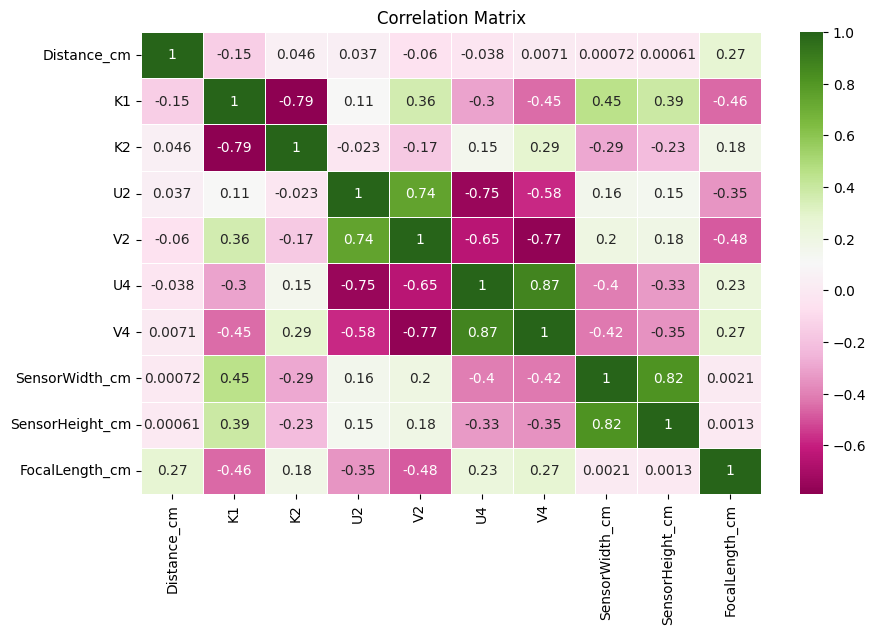

In [22]:
# Load the CSV file into a DataFrame
csv_data = load_training_data(output_csv_path)
print(csv_data.head())

plot_correlations(csv_data)


# PDF
Generates [a PDF](lens_data.pdf) that shows our each of our lens data over distances.

In [23]:
# generate_lens_analysis_plots(csv_data, pdf_path)

# Hide some data

In [24]:
#training_data, hidden_data = prepare_training_data(csv_data, 'CameraName', 'Alexa35_OG')
training_data, hidden_data = prepare_training_data(csv_data, 'LensName', 'ARRI-ZEISS_Master_050mm')

print("Hidden data:")
print(hidden_data.head())
print("Training_data:")
print(training_data.head())

unique_lens_names = training_data['LensName'].unique()
print("Unique lens names:")
print(unique_lens_names)

unique_cam_names = training_data['CameraName'].unique()
print("Unique camera names:")
print(unique_cam_names)


Hidden data:
       Distance_cm        K1        K2            U2        U4        V2  \
30697         52.0  0.019133  0.000720  3.091193e-06 -0.000073  0.000068   
30698         54.0  0.018974  0.000689  4.580037e-09 -0.000071  0.000068   
30699         56.0  0.018765  0.000704  1.323636e-06 -0.000076  0.000070   
30700         58.0  0.018548  0.000727  3.398079e-06 -0.000082  0.000073   
30701         60.0  0.018104  0.000775  7.598122e-06 -0.000095  0.000078   

             V4  SensorWidth_cm  SensorHeight_cm  FocalLength_cm  \
30697 -0.000109         2.02185            1.695            4.97   
30698 -0.000111         2.02185            1.695            4.97   
30699 -0.000117         2.02185            1.695            4.97   
30700 -0.000122         2.02185            1.695            4.97   
30701 -0.000134         2.02185            1.695            4.97   

       FocalLengthCommon_mm                 LensName        CameraName  \
30697                    50  ARRI-ZEISS_Master_

# Main

In [29]:
def training_parameters():
    param_dict = {
    'early_stopping_rounds': [10],
    'max_depth': [4],
    'learning_rate': [.01, .1], # n_estimators needs to go up if learning rate goes down
    'n_estimators': [100, 200, 400, 800],
    'reg_alpha': [.01],
    'reg_lambda': [1.5, 2, 2.5],
    'random_state': [42],
    # 'subsample': [0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 1.0],
    # 'device': ['cuda'], # not beneficial for small datasets like ours (16 core cpu)
    }
    return param_dict

Best RMSE: 0.0006512747583944704
Best Parameters: {'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 2.5}
Best RMSE: 0.0019651827078089865
Best Parameters: {'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1.5}


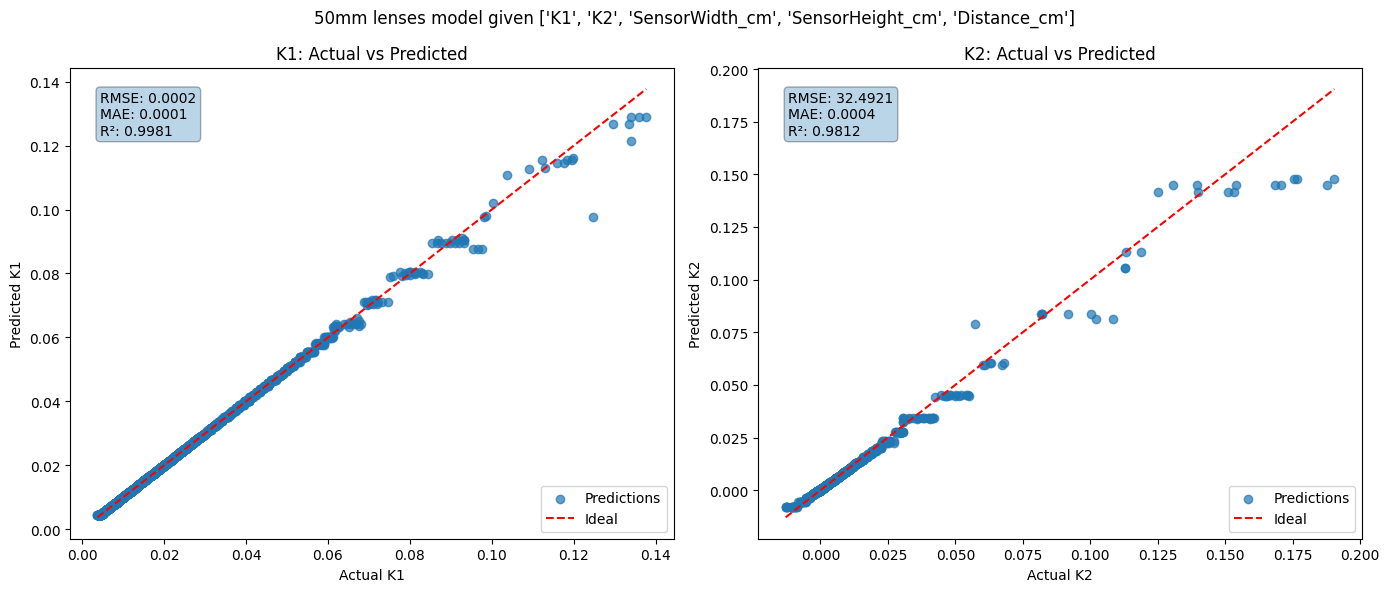

ONNX model saved at: models\50mm_k1.onnx
ONNX model saved at: models\50mm_k2.onnx
Joblib scalers saved at: models\50mm_k1_scaler.joblib models\50mm_k2_scaler.joblib
XGBoost JSON model saved at: models\50mm_k1.json models\50mm_k2.json
         K1        K2  SensorWidth_cm  SensorHeight_cm  Distance_cm
0  0.014903 -0.000562         2.79917            1.922          100
 k1_predicted  k2_predicted
     0.014914     -0.000355


In [32]:
# Use all the original data for training (20% still hidden while doing the training)
training_data = csv_data # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


focal_length_features = ['K1', 'K2', 'SensorWidth_cm', 'SensorHeight_cm', 'Distance_cm']
focal_length_targets = ['K1t', 'K2t']

focal_name = 50
focal_data = get_focal_length_data(training_data, focal_name)

fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler = train(focal_data, focal_length_features, focal_length_targets, training_parameters())
plot_predictions(focal_data, fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler, focal_length_features, focal_length_targets, fig_title=f"{focal_name}mm lenses model given {focal_length_features}")
save_trained_models(fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler, focal_length_features, model_dir, f"{focal_name}mm")

camera_name = 'Alexa35_OG'
distance = 100
#camera_name = 'RED_Dragon_4k_HD'
sensor_width, sensor_height = get_camera_sensor_size(camera_name, focal_data)
k1, k2 = get_distortion(camera_name, distance, focal_data)

X_features = pd.DataFrame({
        'K1': [k1],  # K1 source
        'K2': [k2],  # K2 source
        'SensorWidth_cm': [sensor_width],
        'SensorHeight_cm': [sensor_height],
        'Distance_cm': [distance]
    })

TestPrediction(fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler, X_features)


Best RMSE: 0.0006614108364827291
Best Parameters: {'early_stopping_rounds': 10, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1.5}
Best RMSE: 0.0002978311555490444
Best Parameters: {'early_stopping_rounds': 10, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800, 'random_state': 42, 'reg_alpha': 0.01, 'reg_lambda': 1.5}


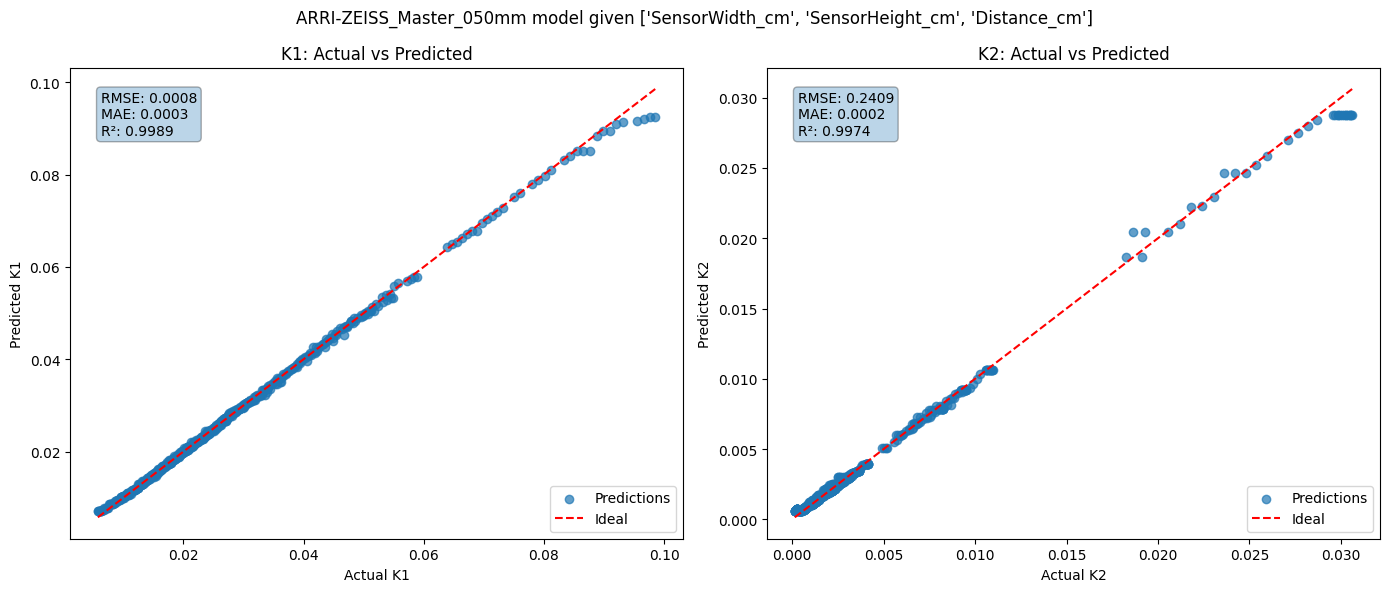

ONNX model saved at: models\ARRI-ZEISS_Master_050mm_k1.onnx
ONNX model saved at: models\ARRI-ZEISS_Master_050mm_k2.onnx
Joblib scalers saved at: models\ARRI-ZEISS_Master_050mm_k1_scaler.joblib models\ARRI-ZEISS_Master_050mm_k2_scaler.joblib
XGBoost JSON model saved at: models\ARRI-ZEISS_Master_050mm_k1.json models\ARRI-ZEISS_Master_050mm_k2.json
   SensorWidth_cm  SensorHeight_cm  Distance_cm
0        2.799171            1.922          100
 k1_predicted  k2_predicted
     0.024989      0.002924


In [31]:
lens_features = ['SensorWidth_cm', 'SensorHeight_cm', 'Distance_cm']
lens_targets = ['K1', 'K2']

lens_name = 'ARRI-ZEISS_Master_050mm'
lens_data = get_lens_data(training_data, lens_name)

lens_k1_model, lens_k2_model, lens_k1_scaler, lens_k2_scaler = train(lens_data, lens_features, lens_targets, training_parameters())
plot_predictions(lens_data, lens_k1_model, lens_k2_model, lens_k1_scaler, lens_k2_scaler, lens_features, lens_targets, fig_title=f"{lens_name} model given {lens_features}")
save_trained_models(lens_k1_model, lens_k2_model, lens_k1_scaler, lens_k2_scaler, lens_features, model_dir, f"{lens_name}")

camera_name = 'Alexa35_OG'
#camera_name = 'RED_Dragon_4k_HD'
distance = 100
sensor_width, sensor_height = get_camera_sensor_size(camera_name, csv_data)

X_features = pd.DataFrame({
        'SensorWidth_cm': [sensor_width],
        'SensorHeight_cm': [sensor_height],
        'Distance_cm': [distance]
    })

TestPrediction(lens_k1_model, lens_k2_model, lens_k1_scaler, lens_k2_scaler, X_features)


# Show the important features

In [ ]:
def get_feature_importance(model, feature_names):
    importance = model.feature_importances_
    return sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

print(get_feature_importance(fl_k1_model, focal_length_features))
print(get_feature_importance(fl_k2_model, focal_length_features))
print(get_feature_importance(lens_k1_model, lens_features))
print(get_feature_importance(lens_k2_model, lens_features))

# Train all the focal length models

In [ ]:
unique_focal_lengths = training_data['FocalLengthCommon_mm'].unique()
for fl_common in unique_focal_lengths:
    focal_data = get_focal_length_data(training_data, fl_common)
    fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler = train(focal_data, focal_length_features, focal_length_targets, training_parameters())
    plot_predictions(focal_data, fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler, focal_length_features, focal_length_targets, fig_title=f"{fl_common}mm lenses model given {focal_length_features}")
    save_trained_models(fl_k1_model, fl_k2_model, fl_k1_scaler, fl_k2_scaler, focal_length_features, model_dir, f"{fl_common}mm")